In [ ]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [ ]:
accuracy_train_list=[]
loss_train_list=[]
accuracy_test_list=[]
loss_test_list=[]
model_name_list=[]

In [ ]:
class NN(Model):
  def __init__(self,layers_arr,n_classes) :
    super(NN, self).__init__()
    self.n_classes=n_classes
    self.layers_arr = layers_arr
    self.n_layers = len(layers_arr)
    self.fc = []
    for i in range(self.n_layers-1):
      self.fc.append(layers.Dense(self.layers_arr[i],activation='relu'))

    self.out =  layers.Dense(self.n_classes)

  def call(self,x,is_training=False):
    for i in range(self.n_layers-1):
      x = self.fc[i](x)
    x = self.out(x)   

    if not is_training: # test
      x = tf.nn.softmax(x)
    return x      




In [ ]:
class Mlp():
  def __init__(self,layers_arr,n_classes,learning_rate,optimizer,batch_size,training_steps,model_name,first_5classes=False) :
    self.layers_arr = layers_arr
    self.n_classes = n_classes
    self.learning_rate = learning_rate
    self.batch_size=batch_size
    self.model_name=model_name
    self.training_steps = training_steps
    self.first_5classes=first_5classes
    self.display_step = 100
    self.accuracy_train =[]
    self.loss_train =[]
    self.accuracy_test =[]
    self.loss_test =[]

    self.load_data()
    self.model = NN(self.layers_arr,self.n_classes)

    if optimizer == 'adam':
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    elif optimizer == 'sgd':
        self.optimizer = tf.keras.optimizers.SGD(self.learning_rate)
    elif optimizer == 'rmsprop':
        self.optimizer = tf.keras.optimizers.RMSprop(self.learning_rate)
    elif optimizer == 'adagrad':
        self.optimizer = tf.keras.optimizers.Adagrad(self.learning_rate)
    elif optimizer == 'adadelta':
      self.optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=self.learning_rate)
    elif optimizer == 'adamW':
      self.optimizer=tf.keras.optimizers.AdamW(learning_rate=self.learning_rate)
            
  
  def loss(self,x,y):
    y = tf.cast(y,tf.int64)
    loss_val = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=x)
    return tf.reduce_mean(loss_val)

  def accuracy(self,pred,y):
    correct_prediction  =tf.equal(tf.argmax(pred,1),tf.cast(y,tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)



  def optimize(self,x,y):
    with tf.GradientTape() as g:
      pred = self.model(x,is_training=True)
      loss_val = self.loss(pred,y)
      trainable_variables = self.model.trainable_variables
      grads = g.gradient(loss_val,trainable_variables)
      self.optimizer.apply_gradients(zip(grads, trainable_variables))


  def load_data(self): 
    (x_train, y_train),(x_test, y_test) = mnist.load_data()
    if self.first_5classes:
      mask_train_1 = np.isin(y_train, [0,1,2,3,4])
      mask_test_1 = np.isin(y_test, [0,1,2,3,4])
      mask_5_2 = np.isin(y_test,[5,6,7,8,9])
      self.x_5_2 =x_test[mask_5_2] 
      self.y_5_2 = y_test[mask_5_2]

      self.x_5_2 = np.array(self.x_5_2, np.float32)
      self.x_5_2 = self.x_5_2.reshape([-1, 784])
      self.x_5_2 = self.x_5_2 / 255.

      x_train = x_train[mask_train_1]
      y_train = y_train[mask_train_1]

      x_test = x_test[mask_test_1]
      y_test = y_test[mask_test_1]

    # Convert to float32.
    x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
    # Flatten images to 1-D vector of 784 features (28*28).
    x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
    # Normalize images value from [0, 255] to [0, 1].
    x_train, x_test = x_train / 255., x_test / 255.

    # Use tf.data API to shuffle and batch data.
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1) 
    
    self.train_data = train_data
    self.x_test = x_test
    self.y_test = y_test  


  def plot(self,y_arr,x,labels,title):
    for (index,y) in enumerate(y_arr):
      plt.plot(x, y,label=labels[index]) # labels = legend = model names # titlr= train loss 
      
    plt.title(title)
    plt.xlabel('steps')
    plt.legend()
    
    plt.savefig(title+'.png') 
    plt.show()


  def train(self):
    steps = []
    for step,(batch_x,batch_y) in enumerate(self.train_data.take(self.training_steps), 1):
      self.optimize(batch_x,batch_y)

      if step % self.display_step == 0:
        pred = self.model(batch_x, is_training=True)
        loss = self.loss(pred, batch_y)
        acc = self.accuracy(pred, batch_y)

        self.accuracy_train.append(acc)
        self.loss_train.append(loss)
        steps.append(step)

        test_pred = self.model(self.x_test)
        test_loss = self.loss(test_pred, self.y_test)
        test_acc = self.accuracy(test_pred, self.y_test)
        
        self.accuracy_test.append(test_acc)
        self.loss_test.append(test_loss)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))
   
    # self.plot([self.accuracy_arr,self.loss_arr],steps,['accuracy','loss'])
    # plt.savefig(self.model_name+'.png')
    pred = self.model(self.x_test, is_training=False)
    # rocـfp,rocـtp= roc_curve(self.y_test, pred)

    print("Test Accuracy: %f" % self.accuracy(pred, self.y_test)) 
    return  self.accuracy_train, self.loss_train,steps,self.accuracy_test,self.loss_test,self.model_name


In [ ]:
#mlp = Mlp(layers_arr=[128,256,10],n_classes=10,learning_rate=0.1,optimizer='sgd',batch_size=256,training_steps=2000,model_name='basic model')
mlp = Mlp(layers_arr=[128,256,512,512,512,10],n_classes=10,learning_rate=0.001,optimizer='adamW',batch_size=256,training_steps=2000,model_name='[128,256,512,512,512,10]-adamW-0.001',first_5classes=True)


In [ ]:
accuracy_train,loss_train,steps,accuracy_test,loss_test,model_name=mlp.train()


step: 100, loss: 0.084516, accuracy: 0.968750
step: 200, loss: 0.036619, accuracy: 0.980469
step: 300, loss: 0.018961, accuracy: 0.992188
step: 400, loss: 0.004828, accuracy: 1.000000
step: 500, loss: 0.002273, accuracy: 1.000000
step: 600, loss: 0.004011, accuracy: 1.000000
step: 700, loss: 0.003126, accuracy: 1.000000
step: 800, loss: 0.003453, accuracy: 1.000000
step: 900, loss: 0.001269, accuracy: 1.000000
step: 1000, loss: 0.001683, accuracy: 1.000000
step: 1100, loss: 0.000520, accuracy: 1.000000
step: 1200, loss: 0.004923, accuracy: 1.000000
step: 1300, loss: 0.002334, accuracy: 1.000000
step: 1400, loss: 0.001742, accuracy: 1.000000
step: 1500, loss: 0.001320, accuracy: 1.000000
step: 1600, loss: 0.000839, accuracy: 1.000000
step: 1700, loss: 0.000908, accuracy: 1.000000
step: 1800, loss: 0.000340, accuracy: 1.000000
step: 1900, loss: 0.001161, accuracy: 1.000000
step: 2000, loss: 0.002548, accuracy: 1.000000
Test Accuracy: 0.990270


In [66]:
## for section 2 of hw1
y_pred_5_2 = mlp.model(mlp.x_5_2)
y_pred_5_2 = tf.argmax(y_pred_5_2, 1)

y_test_5_2 = mlp.y_5_2

In [71]:
print('y_test_5_2')
np.array(y_test_5_2[0:10])

y_test_5_2


array([7, 9, 5, 9, 6, 9, 5, 9, 7, 9], dtype=uint8)

In [70]:
print('y_pred_5_2')
np.array(y_pred_5_2[0:10])

y_pred_5_2


array([3, 2, 2, 4, 0, 4, 3, 4, 0, 1])

In [ ]:
accuracy_train_list.append(accuracy_train)
loss_train_list.append(loss_train)
accuracy_test_list.append(accuracy_test)
loss_test_list.append(loss_test)
model_name_list.append(model_name)

In [ ]:
pred_y = mlp.model(mlp.x_test)
ground_y = mlp.y_test
accuracy_score(ground_y, tf.argmax(pred_y, axis=1))

0.9754

In [ ]:
precision_score(ground_y, tf.argmax(pred_y, axis=1), average='weighted')

0.975693460400161

In [ ]:
recall_score(ground_y, tf.argmax(pred_y, axis=1), average='weighted')

0.9754

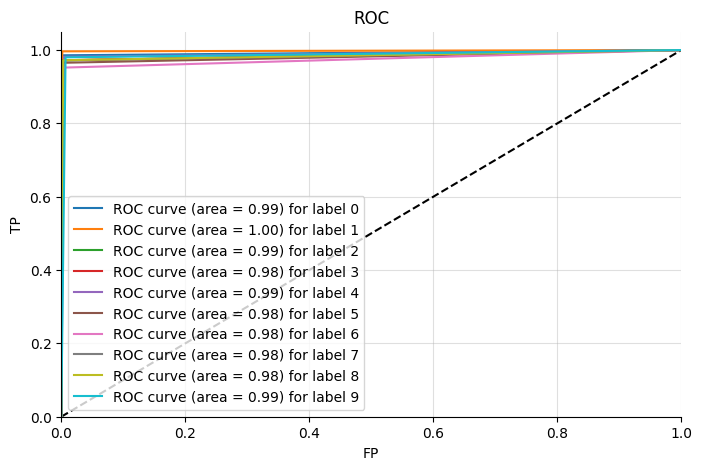

In [ ]:
def multiclass_roc(y_test, y_score, n_classes=10, figsize=(17, 6)):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP')
    ax.set_ylabel('TP')
    ax.set_title('ROC')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend()
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

multiclass_roc(tf.one_hot(ground_y, depth=10), tf.one_hot(tf.argmax(pred_y, axis=1), depth=10), figsize=(8, 5))

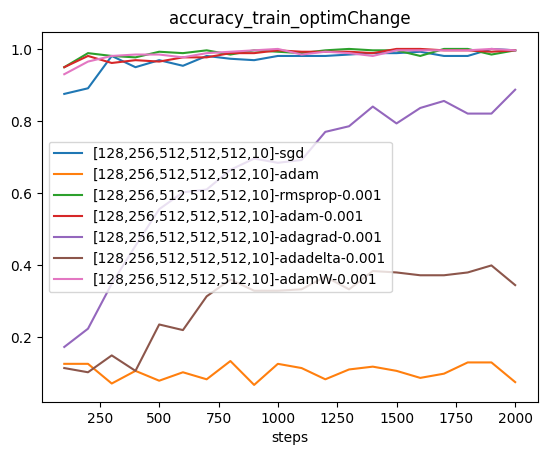

In [ ]:
mlp.plot(y_arr=accuracy_train_list,x=steps,labels=model_name_list,title='accuracy_train_optimChange')


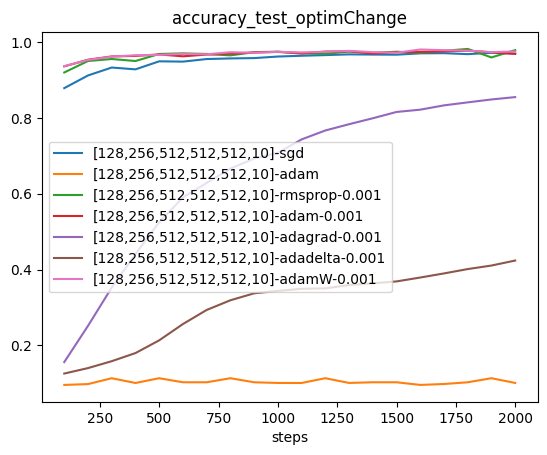

In [ ]:
mlp.plot(y_arr=accuracy_test_list,x=steps,labels=model_name_list,title='accuracy_test_optimChange')

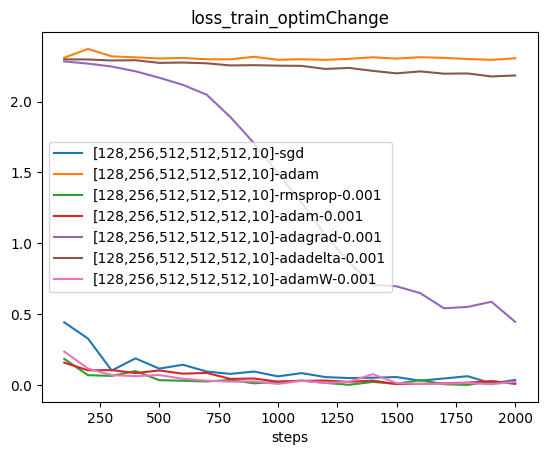

In [ ]:
mlp.plot(y_arr=loss_train_list,x=steps,labels=model_name_list,title='loss_train_optimChange')

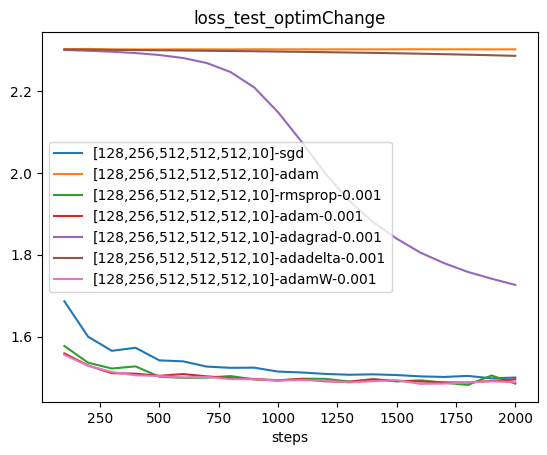

In [ ]:
mlp.plot(y_arr=loss_test_list,x=steps,labels=model_name_list,title='loss_test_optimChange')

In [ ]:
mlp.model.summary()

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  100480    
                                                                 
 dense_1 (Dense)             multiple                  33024     
                                                                 
 dense_2 (Dense)             multiple                  131584    
                                                                 
 dense_3 (Dense)             multiple                  262656    
                                                                 
 dense_4 (Dense)             multiple                  262656    
                                                                 
 dense_5 (Dense)             multiple                  5130      
                                                                 
Total params: 795,530
Trainable params: 795,530
Non-trainable pa